# Exploring Benchmark Dataset
This notebook explores the **AptaBench unified dataset** through descriptive statistics, distribution analysis, and visualization of dataset diversity and splitting strategies.  

# 1. Imports & Config

In [1]:
# Add project root to sys.path so "src" is importable
import sys
from pathlib import Path

root = Path.cwd()
while not (root / "src").exists() and root.parent != root:
    root = root.parent

sys.path.insert(0, str(root))

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.viz.plots import (
    describe_datasets_with_mw_and_logp,
    plot_dataset_distributions,
    cluster_and_plot_tsne_from_combined,
    compare_split_strategies,
    compute_intersections
)
from src.encoders.aptamer_encoders import onehot_with_type_bit
from src.encoders.molecule_encoders import morgan_fp
from src.data.split import (
    stratified_group_splits,
    disjoint_molecule_splits,
    disjoint_aptamer_splits
)

c:\Users\m19er\AptaBench\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load dataset

In [3]:
DATASET_PATH = "../dataset/AptaBench_dataset.csv"
df = pd.read_csv(DATASET_PATH)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.info()
print("\nMissing values per column:")
print(df.isna().sum())

# Check unique sources
print("\nSources available in dataset:")
print(df["source"].value_counts())

Dataset loaded: 2001 rows, 8 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              2001 non-null   object 
 1   sequence          2001 non-null   object 
 2   canonical_smiles  2001 non-null   object 
 3   pKd_value         1161 non-null   float64
 4   label             2001 non-null   int64  
 5   buffer            1049 non-null   object 
 6   origin            1479 non-null   object 
 7   source            2001 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 125.2+ KB

Missing values per column:
type                  0
sequence              0
canonical_smiles      0
pKd_value           840
label                 0
buffer              952
origin              522
source                0
dtype: int64

Sources available in dataset:
source
Manual          654
RSAPred         513
Aptamer Base

# 3. Dataset Summary

In [4]:
dataset_dict = {source: df[df["source"] == source].copy() for source in df["source"].unique()}
dataset_dict['Combined'] = df

summary_stats = describe_datasets_with_mw_and_logp(dataset_dict)
summary_stats

,Dataset,N rows,N unique aptamers,DNA:RNA ratio,Mean aptamer length ± std,N unique molecules,Mean MW ± std,Mean logP ± std,N with pKd,Active:Inactive
0,RSAPred,513,139,22:491,33.1 ± 21.7,195,517.3 ± 227.1,-0.71 ± 4.32,513,455:58
1,Aptamer Base,334,312,205:129,55.3 ± 24.7,52,779.7 ± 1158.0,-1.63 ± 6.64,148,323:11
2,AptaGen,36,35,19:17,38.8 ± 17.8,27,832.6 ± 1390.6,-1.84 ± 5.53,30,33:3
3,UTexas,122,117,76:46,80.4 ± 26.4,47,767.8 ± 974.5,1.57 ± 7.35,103,111:11
4,Ribocentre,85,84,0:85,77.1 ± 37.6,37,479.8 ± 470.4,-0.30 ± 4.49,0,85:0
5,AptaDB,257,230,192:65,58.4 ± 22.8,88,531.2 ± 798.9,-0.30 ± 3.80,0,257:0
6,Manual,654,515,516:138,45.2 ± 20.4,157,372.2 ± 223.8,0.02 ± 3.10,367,578:76
7,Combined,2001,1309,1030:971,48.9 ± 26.7,479,534.8 ± 677.4,-0.44 ± 4.73,1161,1842:159


# 4. Distribution Plots

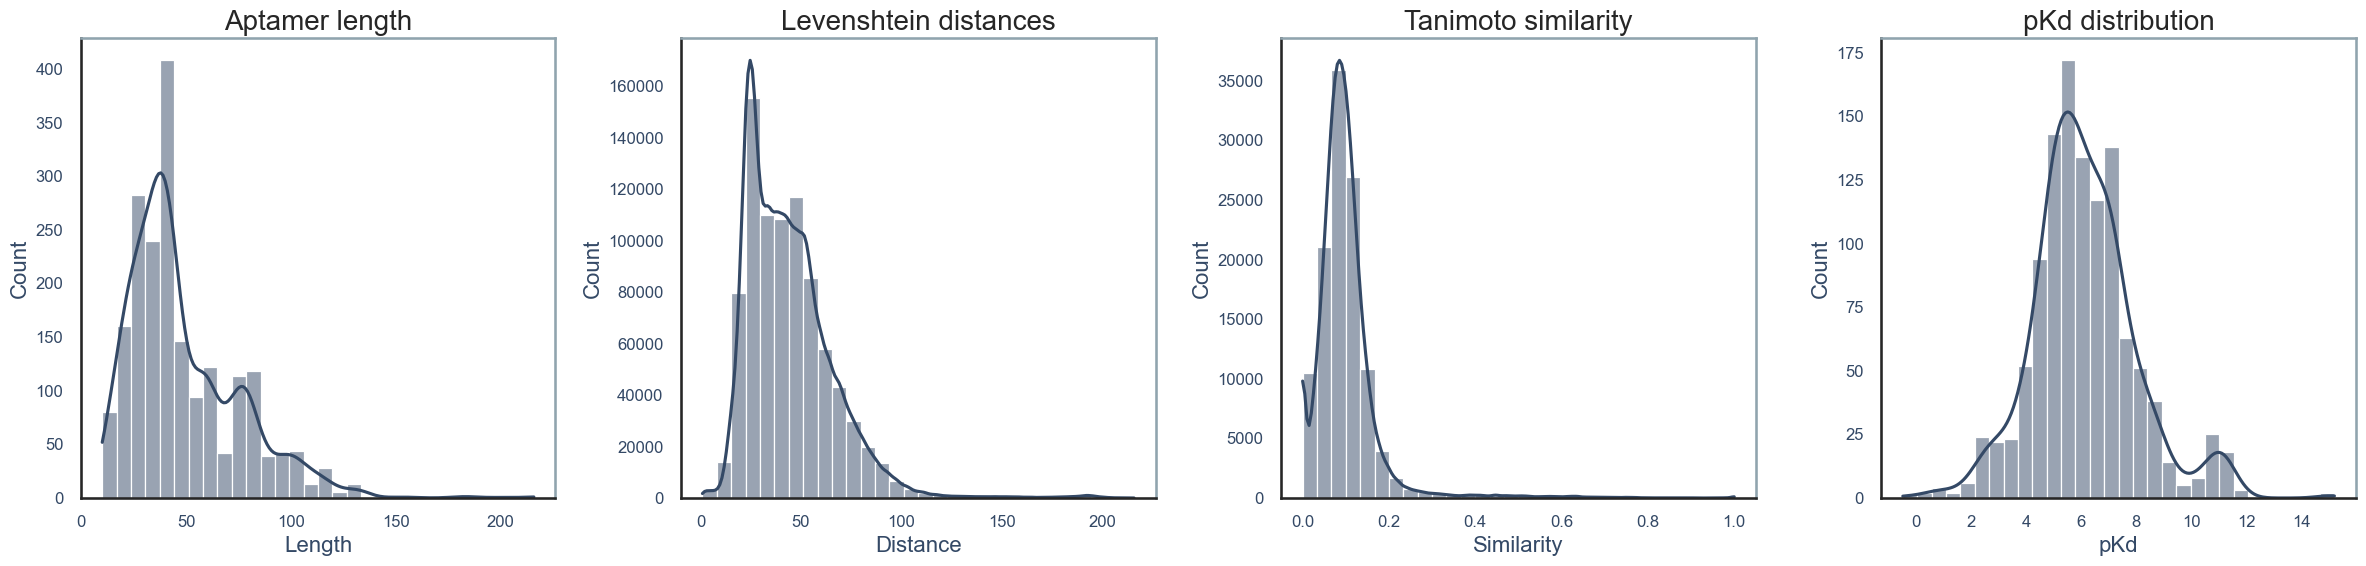

In [8]:
plot_dataset_distributions(df)

# 5. Vizualize splits

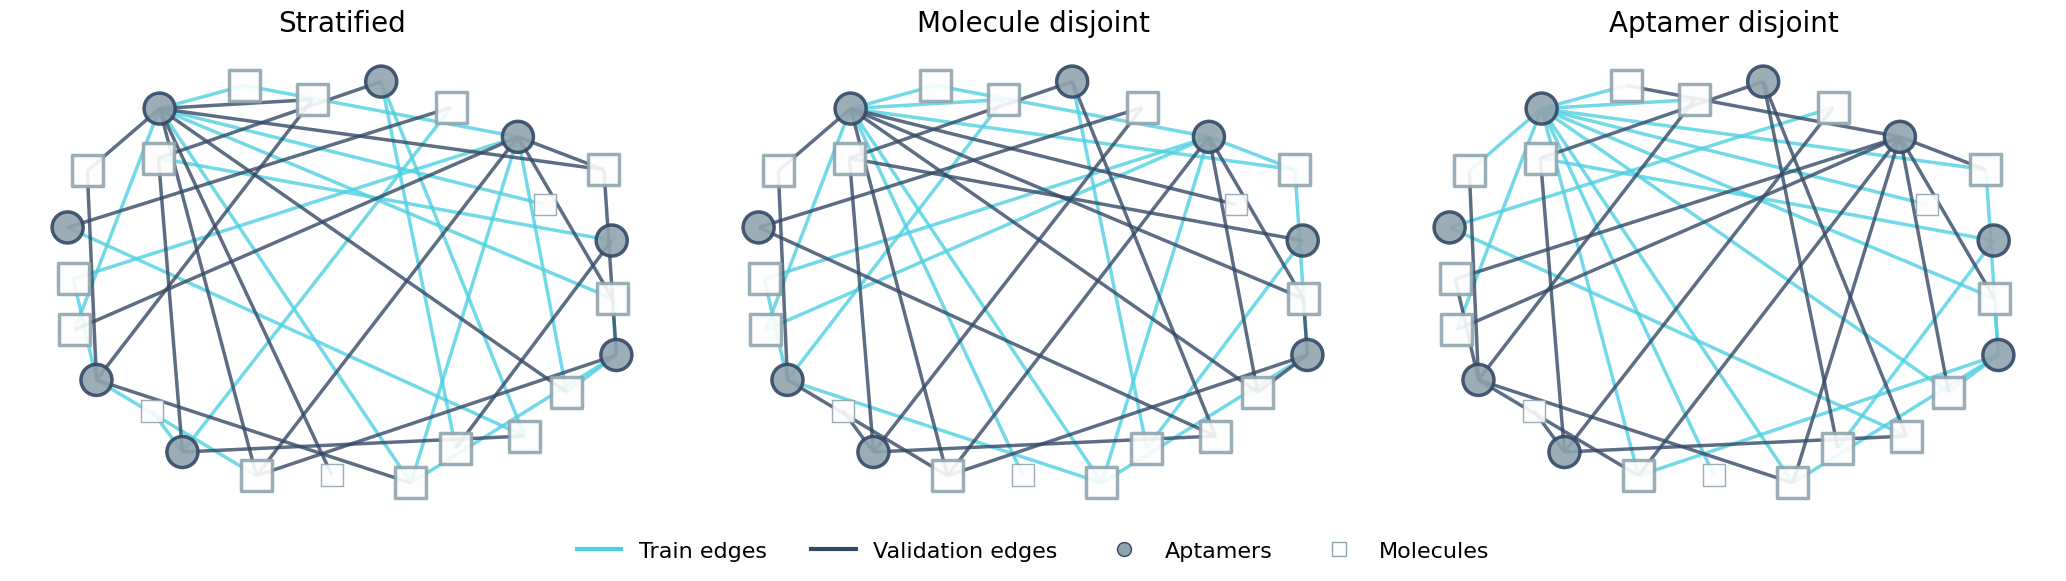

In [6]:
sample = df.iloc[30:70]
splits_stratified = stratified_group_splits(sample, n_splits=2, random_state=42)
splits_molecule_disjoint = disjoint_molecule_splits(sample, n_splits=2, random_state=42)
splits_aptamer_disjoint = disjoint_aptamer_splits(sample, n_splits=2, random_state=42)

compare_split_strategies(
    sample,
    {
        "Stratified": splits_stratified,
        "Molecule disjoint": splits_molecule_disjoint,
        "Aptamer disjoint": splits_aptamer_disjoint
    }
)

# 6. t-SNE Visualization

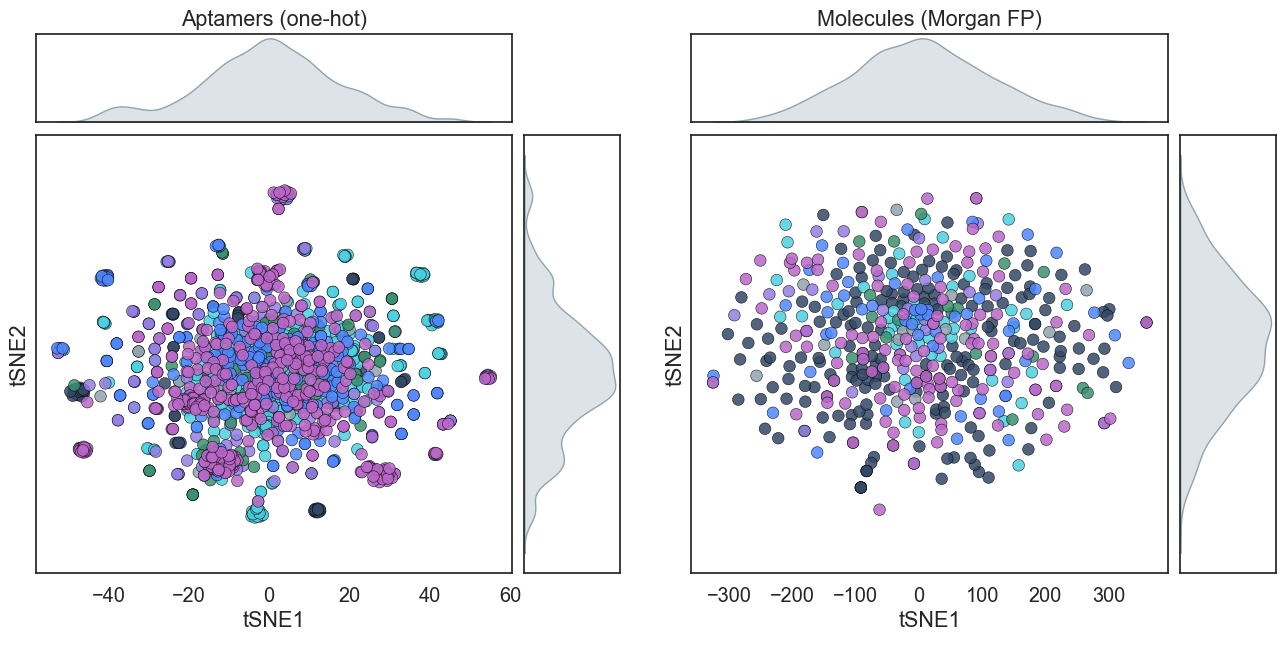

In [7]:
cluster_and_plot_tsne_from_combined(
    df,
    aptamer_encoder=onehot_with_type_bit,
    molecule_encoder=morgan_fp,
    source_col="source"
)

# 7. Intersection between sources

In [4]:
df_intersections = compute_intersections(df, source_col="source")
df_intersections

,RSAPred,Aptamer Base,AptaGen,UTexas,Ribocentre,AptaDB,Manual
RSAPred,487/139/195,0/0/4,0/1/5,0/0/5,2/4/12,0/1/7,8/2/19
Aptamer Base,0/0/4,312/312/52,2/2/6,6/7/15,1/1/7,2/2/9,1/12/7
AptaGen,0/1/5,2/2/6,36/35/27,0/0/6,2/3/6,10/10/13,2/5/9
UTexas,0/0/5,6/7/15,0/0/6,121/117/47,18/18/9,2/2/13,1/6/10
Ribocentre,2/4/12,1/1/7,2/3/6,18/18/9,85/84/37,0/1/7,1/1/11
AptaDB,0/1/7,2/2/9,10/10/13,2/2/13,0/1/7,257/230/88,20/55/14
Manual,8/2/19,1/12/7,2/5/9,1/6/10,1/1/11,20/55/14,640/515/157
